In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, ColorJitter, Compose, Normalize

from torch import nn
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import BatchNorm2d
from torch.nn import LSTM
from torch import flatten
from torchmetrics import CharErrorRate
import torch.nn.functional as F
from torch.nn import CTCLoss

# Prepare data

### Alphabet class

In [3]:
class Alphabet(object):
    def __init__(self, folder_path):
        self.symbol2idx = {}
        self.idx2symbol = []
        self._len = 0
        self.make_alphabet(folder_path)
        
    def add_symbol(self, s):
        if s not in self.symbol2idx:
            self.idx2symbol.append(s)
            self.symbol2idx[s] = self._len
            self._len += 1
            
    def make_alphabet(self, folder_path):
        assert os.path.exists(folder_path)
        for _, _, files in os.walk(folder_path):
            for file_name in files:
                file_name = file_name.split('.')[0]
                for symbol in file_name:
                    self.add_symbol(symbol)
        
    def __len__(self):
        return self._len
    
    def encode(self, label):
        ids = torch.zeros([len(label), len(self)], dtype=torch.float32)
        for pos, symbol in enumerate(label):
            ids[pos, self.symbol2idx[symbol]] = 1.
        return ids
    
    def decode(self, ids):
        idxs = ids.argmax(dim=2).tolist()
        labels = [''.join([self.idx2symbol[i] for i in b]) for b in idxs]
        return labels

In [4]:
img_dir = './samples/'

alphabet = Alphabet(img_dir)

### Dataset class

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = []
        for _, _, files in os.walk(img_dir):
            for file_ in files:
                self.img_labels.append(file_)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert('RGB')
        label = alphabet.encode(filename.split('.')[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Train/Test split

In [6]:
all_files = []
for _, _, files in os.walk(img_dir):
    for file_ in files:
        all_files.append(file_)
        
random.shuffle(all_files)
border = int(0.8 * len(all_files))
train_files = all_files[:border]
test_files = all_files[border:]

In [7]:
train_data_dir = 'data/train/'
test_data_dir = 'data/test/'

if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)
    for file in train_files:
        shutil.copy(os.path.join(img_dir, file), train_data_dir)

if not os.path.exists(test_data_dir):
    os.makedirs(test_data_dir)
    for file in test_files:
        shutil.copy(os.path.join(img_dir, file), test_data_dir)

In [8]:
train_dataset = CustomImageDataset(img_dir=train_data_dir,
                                   transform=Compose([
                                            #ColorJitter(),
                                            ToTensor(),
                                            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                   ]))

test_dataset = CustomImageDataset(img_dir=test_data_dir,
                                  transform=Compose([
                                            ToTensor(),
                                            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                 ]))

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### Find mean and std of dataset

In [10]:
nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(train_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.4305, 0.4305, 0.4305])
tensor([0.6269, 0.6269, 0.6269])


In [11]:
train_dataset = CustomImageDataset(img_dir=train_data_dir,
                                   transform=Compose([
                                            #ColorJitter(),
                                            ToTensor(),
                                            Normalize(mean=[0.4304, 0.4304, 0.4304], std=[0.6269, 0.6269, 0.6269]),
                                   ]))

test_dataset = CustomImageDataset(img_dir=test_data_dir,
                                  transform=Compose([
                                            ToTensor(),
                                            Normalize(mean=[0.4304, 0.4304, 0.4304], std=[0.6269, 0.6269, 0.6269]),
                                 ]))

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

## Create Model


In [13]:
class Bidirectional_LSTM(torch.nn.Module):
    def __init__(self, class_num, hidden_unit):
        super(Bidirectional_LSTM, self).__init__()
        self.LSTM1 = torch.nn.LSTM(1024, hidden_unit, bidirectional=True)
        self.embedding1 = torch.nn.Linear(hidden_unit * 2, 1024)
        self.LSTM2 = torch.nn.LSTM(1024, hidden_unit, bidirectional=True)
        self.embedding2 = torch.nn.Linear(hidden_unit * 2, class_num)

    def forward(self, x):
        x = self.LSTM1(x)   # LSTM output: output, (h_n, c_n)
        T, b, h = x[0].size()   # x[0]: (seq_len, batch, num_directions * hidden_size)
        x = self.embedding1(x[0].view(T * b, h))  # pytorch view() reshape as [T * b, nOut]
        x = x.view(T, b, -1)  # [seq_len, b, 512]
        x = self.LSTM2(x)
        T, b, h = x[0].size()
        x = self.embedding2(x[0].view(T * b, h))
        x = x.view(T, b, -1)
        return x


In [14]:
class CapchaNet(Module):
    def __init__(self, alphabet_len):
        super(CapchaNet, self).__init__()
        
        self.conv1 = Conv2d(3, 64, (3, 3), stride=2) # 99x24
        self.bn1 = BatchNorm2d(64)
        self.conv2 = Conv2d(64, 128, (3, 3), stride=2) # 48x11
        self.bn2 = BatchNorm2d(128)
        self.conv3 = Conv2d(128, 256, (3, 3), stride=2) # 23x5
        self.bn3 = BatchNorm2d(256)
        self.conv4 = Conv2d(256, 512, (3, 3), stride=2) # 11x2
        self.bn4 = BatchNorm2d(512)
        self.conv5 = Conv2d(512, 1024, (2, 2), stride=(1, 2)) # 5X1
        self.bn5 = BatchNorm2d(1024)
        # self.glob_pool = AdaptiveAvgPool2d((1,1)) 
        self.rnn = Bidirectional_LSTM(alphabet_len, 1024)
        # self.fc1 = Linear(9 * 5 * 512, 512)
        # self.fc2 = Linear(512, alphabet_len * 5)

    
    def forward(self, x):
        
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        # x = self.glob_pool(x)
        # x = flatten(x, start_dim=1)
        
        x = x.squeeze(2)  # remove h dimension
        x = x.permute(2, 0, 1)  # [w, b, c] = [seq_len, batch, input_size]
        x = self.rnn(x)
        x = x.permute(1, 0, 2)
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        # x = x.view(-1, 5, 19)
        output = F.log_softmax(x, dim=2) 
        return output

## Train

In [15]:
import string
import math
from torch.optim import lr_scheduler

ntokens = len(alphabet)
model = CapchaNet(ntokens)
criterion = nn.CrossEntropyLoss()
grad_clip = 0.1
lr = torch.tensor(1e-3)
optim = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optim, mode='min',
                                           factor=0.4, patience=3, verbose=True)

In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [17]:
def character_error_rate(preds, labels):
    assert len(preds) == len(labels)
    errors = 0
    for pred, label in zip(preds, labels):
        for p, l in zip(pred, label):
            errors += int(p != l)
    return errors / (len(labels) * len(labels[0]))

In [18]:
def train(model):
    
    model.train()
    total_loss = 0
    total_val_loss = 0
    cer, cer_p = 0, 0
    CER = CharErrorRate()
    for batch, (data, targets) in enumerate(train_loader):
        
        output = model(data)
        optim.zero_grad()
        loss = criterion(output, targets)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optim.step()
        total_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            preds = model(data)
            val_loss = criterion(preds, targets)
            total_val_loss += val_loss.item()
            labels = alphabet.decode(targets)
            pred_labels = alphabet.decode(preds)
            cer_p += CER(pred_labels, labels)
            cer += character_error_rate(pred_labels, labels)
            
    
    total_loss /= len(train_loader)
    total_val_loss /= len(test_loader)
    cer /= len(test_loader)
    cer_p /= len(test_loader)
    
    scheduler.step(total_val_loss)
    
    print('[Epoch {:3d}]:  lr {:02.6f} | train loss {:5.5f} | val loss {:5.5f} | val CER {:5.5f} | val CER(torch) {:5.5f}'.format(
                epoch, get_lr(optim), total_loss, total_val_loss, cer, cer_p))
    return total_loss, total_val_loss

In [19]:
loss_curve_train, loss_curve_test = [], []

In [20]:
for epoch in range(1, 60):
    train_loss, test_loss = train(model)
    loss_curve_train.append(train_loss)
    loss_curve_test.append(test_loss)

[Epoch   1]:  lr 0.001000 | train loss 0.26901 | val loss 0.29594 | val CER 0.83023 | val CER(torch) 0.83023
[Epoch   2]:  lr 0.001000 | train loss 0.11948 | val loss 0.12212 | val CER 0.42694 | val CER(torch) 0.42694
[Epoch   3]:  lr 0.001000 | train loss 0.08094 | val loss 0.07452 | val CER 0.25542 | val CER(torch) 0.25542
[Epoch   4]:  lr 0.001000 | train loss 0.06473 | val loss 0.06164 | val CER 0.19603 | val CER(torch) 0.19603
[Epoch   5]:  lr 0.001000 | train loss 0.05476 | val loss 0.05753 | val CER 0.14289 | val CER(torch) 0.14289
[Epoch   6]:  lr 0.001000 | train loss 0.05600 | val loss 0.05424 | val CER 0.12148 | val CER(torch) 0.12148
[Epoch   7]:  lr 0.001000 | train loss 0.04862 | val loss 0.04956 | val CER 0.10632 | val CER(torch) 0.10632
[Epoch   8]:  lr 0.001000 | train loss 0.05002 | val loss 0.05106 | val CER 0.12076 | val CER(torch) 0.12076
[Epoch   9]:  lr 0.001000 | train loss 0.05257 | val loss 0.05712 | val CER 0.14445 | val CER(torch) 0.14445
[Epoch  10]:  lr 0.

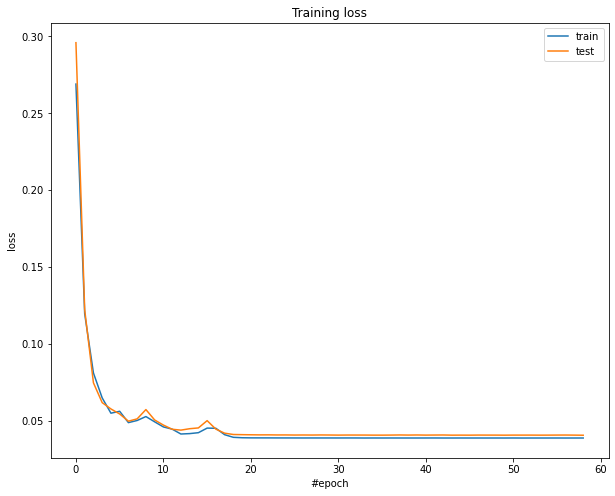

In [21]:
# Visualize loss
plt.figure(figsize=(10, 8))
    
plt.title("Training loss")
plt.xlabel("#epoch")
plt.ylabel("loss")

plt.plot(loss_curve_train, label='train')
plt.plot(loss_curve_test, label='test')


#plt.yscale('log',base=2)
plt.legend()
plt.show()